In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy


from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from scipy.stats import norm
import seaborn as sns
import math
from tqdm import tqdm

from nn_backend.import_xyz_img import import_xyz_img
from nn_backend.conv_imgs import conv_imgs
from nn_backend.data_import import import_curves_from_folder, curve_calibration, matrix_cut, data_augment, mask_from_topo
from nn_backend.nn_for_ep import nn_for_ep
from nn_backend.post_process import img_export, histogram_export
from nn_backend.extras import simulation_table_import


viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:13, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

In [85]:
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-5-16-12-17\FlattenTopo_.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-5-16-12-17\Map_Ep.txt"
sim_tables_folder=rf'C:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-5-16-12-17\tablas'
lift_imgs_folder=rf'C:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-5-16-12-17\lifts'
binary_threshold=0.067
object_size=3
hole_size=30
m_ep_thresh=0.30
ref_flip=0


In [86]:
topo, x, y2 = import_xyz_img(topography_file)
og_dim=len(topo)
nu_dim=og_dim
T=topo.reshape(og_dim**2)

In [87]:
y_mat, ax_ep, ay_ep= import_xyz_img(ref_file)
if ref_flip:
    y_mat=np.flipud(y_mat)
y=np.reshape(y_mat,nu_dim**2)

In [88]:
use_lift_files=1
if use_lift_files:
    lifts=[20,30,40,80,150]
    samples=lifts
    lift_samples=np.zeros((og_dim,og_dim,1))
    for l in lifts:
        file, ax_ep, ay_ep= import_xyz_img(rf'{lift_imgs_folder}\LiftPower_{l}_.txt')
        file=np.expand_dims(file,axis=-1)
        lift_samples=np.concatenate((lift_samples,file), axis=-1)
        
    lift_samples=lift_samples[:,:,1:]

C:\Users\mcano\AppData\Local\Temp\ipykernel_4432\2564657816.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))


Text(0.5, 1.0, 'Final Train Mask')

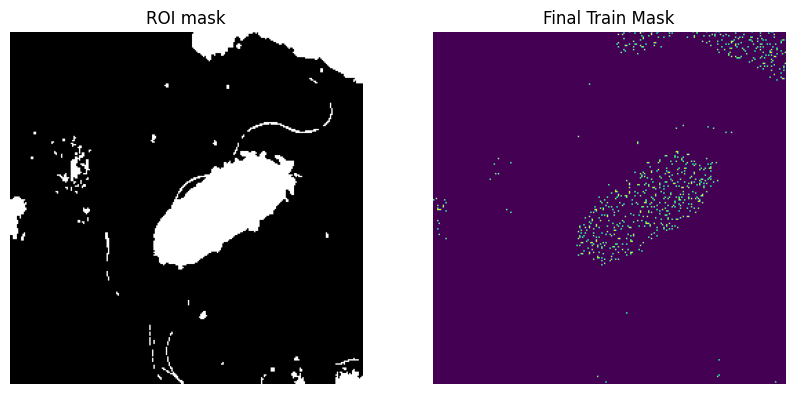

In [89]:
masker=T

bin=mask_from_topo(masker,binary_threshold,object_size,hole_size)

cell=bin.reshape(nu_dim**2,1)
roi_index=pd.DataFrame(copy(cell))
roi_index=roi_index.index[(roi_index[0])]


mask_ep=pd.DataFrame(copy(y))
th=float(mask_ep.quantile(m_ep_thresh))

mask_ep[(mask_ep[0]<=th)]=0
mask_ep[(mask_ep[0]!=0)]=1
mask_ep=cell*mask_ep
mask_ep_im=np.reshape(np.array(mask_ep), ((nu_dim),(nu_dim)))

cell_index=mask_ep.index[mask_ep[0]>0].tolist()


fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(1,2,1)
ax.imshow(bin, cmap='gray')
ax.set_title('ROI mask')
ax.axis('off')
ax=fig.add_subplot(1,2,2)
ax.imshow(mask_ep_im)
ax.axis('off')
ax.set_title('Final Train Mask')

In [90]:
def conv_imgss(matrix,kernel_size, idx=[]):

    if len(idx)<=0:
        ix=0
        iy=0
        samps=np.zeros((1, kernel_size,kernel_size))

        for j in tqdm(np.arange(len(matrix)-kernel_size+1)):
            iy=j
            for i in np.arange(len(matrix[0])-kernel_size+1):
                ix=i
                samp=matrix[iy:iy+kernel_size,ix:ix+kernel_size]
                samp=np.expand_dims(samp, axis=0)
                samps=np.concatenate((samps,samp), axis=0)
        samps=samps[1:,:,:]
    else:
        if kernel_size%2 == 0:
            extra=0
        else:
            extra=1
        half_kernel=int(np.round((kernel_size-1)/2))

        ix=0
        iy=0
        samps=np.zeros((1, kernel_size,kernel_size))
        skipped=0
        for j in tqdm(np.arange(len(idx[0,:]))):
            iy=idx[0,j]
            ix=idx[1,j]
            y_start=iy-half_kernel
            y_stop=iy+half_kernel+extra
            x_start=ix-half_kernel
            x_stop=ix+half_kernel+extra

            check_indexes=np.array([y_start,y_stop,x_start,x_stop])

            if np.any(check_indexes<0) or np.any(check_indexes>256):
                skipped+=1
            else:
                samp=matrix[iy-half_kernel:iy+half_kernel+extra,ix-half_kernel:ix+half_kernel+extra]
                samp=np.expand_dims(samp, axis=0)
                samps=np.concatenate((samps,samp), axis=0)
        samps=samps[1:,:,:]
    print(f'{skipped} indexes skipped')
    return samps

In [109]:
cutout_size=79

# y_coord, x_coord= np.unravel_index(cell_index, (nu_dim, nu_dim))
# cell_index_2=np.transpose(np.column_stack((y_coord, x_coord)))
# cell_index_2[0]=cell_index_2[0]+int((cutout_size-1)/2)
# cell_index_2[1]=cell_index_2[1]+int((cutout_size-1)/2)

Cuts=conv_imgss(topo, cutout_size)#, cell_index_2[:,:])
# y_cuts=conv_imgss(y_mat, cutout_size, cell_index_2[:,:])
# bin_cuts=conv_imgss(bin, cutout_size, cell_index_2[:,:])
# L_cuts=np.zeros((576,40,40,1))
# for i in range(len(lifts)):
#     lcut=conv_imgss(lift_samples[:,:,i], cutout_size, cell_index_2[:,:])
#     lcut=np.expand_dims(lcut, axis=3)
#     L_cuts=np.concatenate((L_cuts,lcut), axis=-1)
# L_cuts=L_cuts[:,:,:,1:]


100%|██████████| 178/178 [2:27:11<00:00, 49.61s/it]  


UnboundLocalError: cannot access local variable 'skipped' where it is not associated with a value

In [111]:
nu_dim=og_dim-cutout_size+1
topocut=copy(topo)
topocut=matrix_cut(topocut, nu_dim)
ii=300
print(Cuts[ii,39,39])
print(topocut.reshape(nu_dim**2)[ii])

4.98e-10
3.001e-09


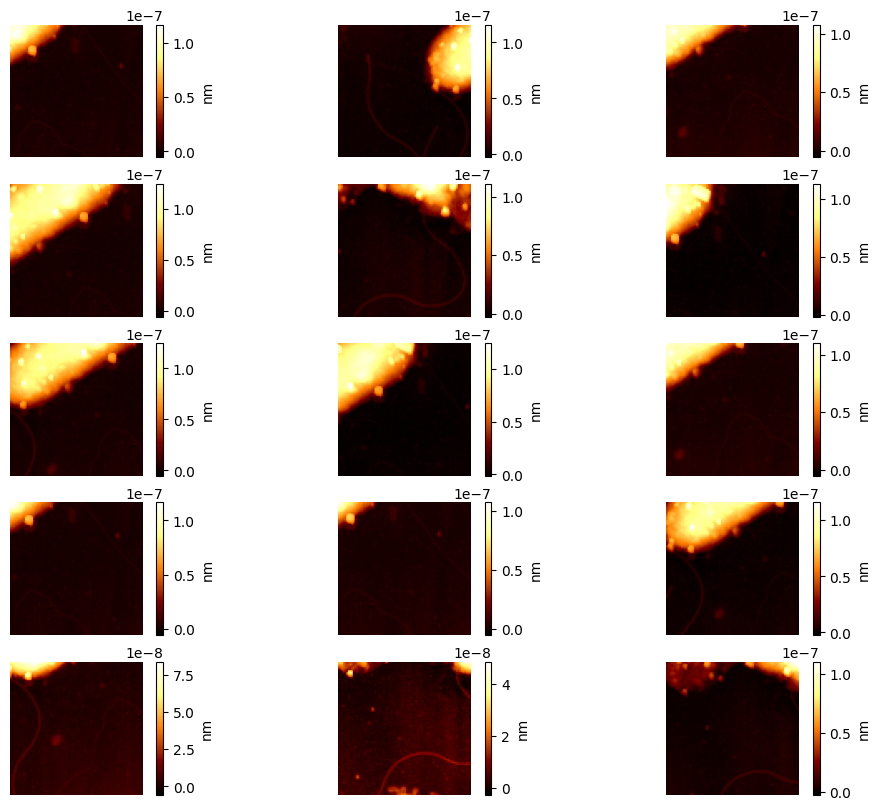

In [102]:
fig=plt.figure(figsize=(12,10))
selection = random_numbers = np.random.randint(0, len(Cuts), size=15)
for i in range(1,16):
    ax=fig.add_subplot(5,3,i)
    pcm=ax.imshow(Cuts[selection[i-1],:,:], cmap='afmhot')
    plt.colorbar(pcm, label="nm")
    ax.axis('off')


In [30]:
ix=150
iy=19
kernel_size=40
if kernel_size%2 == 0:
    extra=0
else:
    extra=1
half_kernel=int(np.round((kernel_size-1)/2))
samp=topo[iy-half_kernel:iy+half_kernel+extra,ix-half_kernel:ix+half_kernel+extra]
# samp=np.expand_dims(samp, axis=0)

In [25]:
print(list(range(10,51)))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [39]:
y_start=54
y_stop=13
x_start=5
x_stop=12
check_indexes=np.array([y_start,y_stop,x_start,x_stop])

if np.any(check_indexes<0) or np.any(check_indexes>256):
    print('error')
else:
    print('todo ok')

todo ok


In [81]:
print(list(range(9)))

[0, 1, 2, 3, 4, 5, 6, 7, 8]
